In [2]:
import pandas as pd
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import math
from rouge import Rouge
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
sns.set()

In [3]:
def show(x):
    print(x.shape)
    return x.head()

In [4]:
references = pd.read_csv("../data/references.csv").set_index("global_reference_id")
show(references)
references.head(20)

(24732, 2)


,title,abstract
global_reference_id,,
0,Distributed Representations of Words and Phras...,The recently introduced continuous Skip-gram m...
1,BERT: Pre-training of Deep Bidirectional Trans...,We introduce a new language representation mod...
2,Attention Is All You Need,The dominant sequence transduction models are ...
3,GloVe : Global Vectors for Word Representation,Recent methods for learning vector space repre...
4,Adam: A Method for Stochastic Optimization,"We introduce Adam, an algorithm for first-orde..."
5,Long Short-Term Memory,NaN
6,Deep Contextualized Word Representations,We introduce a new type of deep contextualized...
7,Neural Machine Translation By Jointly Learning...,Neural machine translation is a recently propo...
8,Efficient Estimation of Word Representations i...,We propose two novel model architectures for c...


In [5]:
papers = pd.read_csv("../data/papers.csv").set_index("paper_id")
show(papers)

(1091, 3)


,title,abstract,text
paper_id,,,
0,IDST at TREC 2019 Deep Learning Track: Deep Ca...,This paper describes our participation in the ...,"KEYWORDS cascade ranking, pre-trained language..."
1,BatchBALD: Efficient and Diverse Batch Acquisi...,"We develop BatchBALD, a tractable approximatio...",A key problem in deep learning is data efficie...
2,A Sentence Compression Based Framework to Quer...,We consider the problem of using sentence comp...,Proceedings of the 51st Annual Meeting of the ...
3,DR-BiLSTM: Dependent Reading Bidirectional LST...,We present a novel deep learning architecture ...,Natural Language Inference (NLI; a.k.a. Recogn...
4,On Minimizing Cost in Legal Document ReviewWor...,Technology-assisted review (TAR) refers to hum...,CCS CONCEPTS • Information systems → Informati...


In [6]:
citations = pd.read_csv("../data/citations.csv")
show(citations)

(56746, 6)


,paper_id,internal_reference_id,global_reference_id,context,start_offset,end_offset
0,0,1,1,Our approach is mainly based on the BERT langu...,56,59
1,0,8,475,Different from many other ranking methods whic...,216,219
2,0,5,155,"Moreover, for full ranking subtask, we use a s...",78,81
3,0,6,25,The proposed model is based on the pointer-gen...,59,62
4,0,6,25,"Following [7], we also use a soft switch to ch...",10,13


In [7]:
citations.context[1]

'Different from many other ranking methods which directly finetune the original BERT model in downstream task, we modify the next sentence prediction task in BERT to a 3-class sentence classification as in StructBERT [9] and pre-train a new BERT language model from scratch.'

In [8]:
citations.groupby(["paper_id", "global_reference_id"]).size()

paper_id  global_reference_id
0         1                      2
          2                      1
          13                     1
          21                     1
          25                     3
                                ..
1090      18917                  1
          20566                  1
          21397                  1
          21484                  1
          23601                  1
Length: 33068, dtype: int64

# rouge against original abstract

In [9]:
retrieved = citations.groupby(["paper_id", "global_reference_id"]).context.sum().reset_index()
show(retrieved)

(33068, 3)


,paper_id,global_reference_id,context
0,0,1,Our approach is mainly based on the BERT langu...
1,0,2,BERT [2] is a self-supervised approach for pre...
2,0,13,"Recently, some variants [4, 12] of BERT langua..."
3,0,21,"Recently, some variants [4, 12] of BERT langua..."
4,0,25,The proposed model is based on the pointer-gen...


In [10]:
retrieved.iloc[1].context

'BERT [2] is a self-supervised approach for pre-training a deep transformer encoder [8], before fine-tuning it for a particular downstream task.'

In [11]:
queries = retrieved.merge(references.drop(columns = "title"), on = "global_reference_id")\
.rename(columns = {"abstract":"reference", "context":"hypothesis", "text":"paper_text"})\
.dropna()\
.reset_index(drop = True)
show(queries)

(10984, 4)


,paper_id,global_reference_id,hypothesis,reference
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...
1,7,1,"BERT (Devlin et al., 2019) and its improvement...",We introduce a new language representation mod...
2,8,1,performed by pretrained language models (LMs) ...,We introduce a new language representation mod...
3,12,1,[118] proposed a new language representation m...,We introduce a new language representation mod...
4,17,1,"In particular, Bidirectional Encoder Represent...",We introduce a new language representation mod...


In [12]:
rouge = Rouge()
scores = rouge.get_scores(hyps = queries.hypothesis, refs = queries.reference)
print(len(scores))
scores[:5]

10984


[{'rouge-1': {'r': 0.11607142857142858,
   'p': 0.3939393939393939,
   'f': 0.17931034131177173},
  'rouge-2': {'r': 0.014084507042253521,
   'p': 0.04878048780487805,
   'f': 0.021857920020305732},
  'rouge-l': {'r': 0.10714285714285714,
   'p': 0.36363636363636365,
   'f': 0.1655172378634959}},
 {'rouge-1': {'r': 0.13392857142857142,
   'p': 0.22058823529411764,
   'f': 0.16666666196543226},
  'rouge-2': {'r': 0.007042253521126761,
   'p': 0.012345679012345678,
   'f': 0.008968605239601008},
  'rouge-l': {'r': 0.13392857142857142,
   'p': 0.22058823529411764,
   'f': 0.16666666196543226}},
 {'rouge-1': {'r': 0.16964285714285715,
   'p': 0.2159090909090909,
   'f': 0.18999999507200013},
  'rouge-2': {'r': 0.007042253521126761,
   'p': 0.008547008547008548,
   'f': 0.00772200276859637},
  'rouge-l': {'r': 0.16071428571428573,
   'p': 0.20454545454545456,
   'f': 0.17999999507200018}},
 {'rouge-1': {'r': 0.24107142857142858,
   'p': 0.39705882352941174,
   'f': 0.2999999952987655},
  'r

In [13]:
rouge_df = pd.DataFrame.from_records(scores)
show(rouge_df)

(10984, 3)


,rouge-1,rouge-2,rouge-l
0,"{'r': 0.11607142857142858, 'p': 0.393939393939...","{'r': 0.014084507042253521, 'p': 0.04878048780...","{'r': 0.10714285714285714, 'p': 0.363636363636..."
1,"{'r': 0.13392857142857142, 'p': 0.220588235294...","{'r': 0.007042253521126761, 'p': 0.01234567901...","{'r': 0.13392857142857142, 'p': 0.220588235294..."
2,"{'r': 0.16964285714285715, 'p': 0.215909090909...","{'r': 0.007042253521126761, 'p': 0.00854700854...","{'r': 0.16071428571428573, 'p': 0.204545454545..."
3,"{'r': 0.24107142857142858, 'p': 0.397058823529...","{'r': 0.1267605633802817, 'p': 0.24, 'f': 0.16...","{'r': 0.23214285714285715, 'p': 0.382352941176..."
4,"{'r': 0.24107142857142858, 'p': 0.333333333333...","{'r': 0.07042253521126761, 'p': 0.104166666666...","{'r': 0.24107142857142858, 'p': 0.333333333333..."


In [14]:
rouge_1 = pd.DataFrame.from_records(rouge_df["rouge-1"])\
.rename(columns = {"f":"rouge_1_f", "r":"rouge_1_r", "p":"rouge_1_p"})
show(rouge_1)

(10984, 3)


,rouge_1_r,rouge_1_p,rouge_1_f
0,0.116071,0.393939,0.179310
1,0.133929,0.220588,0.166667
2,0.169643,0.215909,0.190000
3,0.241071,0.397059,0.300000
4,0.241071,0.333333,0.279793


In [15]:
rouge_2 = pd.DataFrame.from_records(rouge_df["rouge-2"])\
.rename(columns = {"f":"rouge_2_f", "r":"rouge_2_r", "p":"rouge_2_p"})
show(rouge_2)

(10984, 3)


,rouge_2_r,rouge_2_p,rouge_2_f
0,0.014085,0.048780,0.021858
1,0.007042,0.012346,0.008969
2,0.007042,0.008547,0.007722
3,0.126761,0.240000,0.165899
4,0.070423,0.104167,0.084034


In [16]:
rouge_l = pd.DataFrame.from_records(rouge_df["rouge-l"])\
.rename(columns = {"f":"rouge_l_f", "r":"rouge_l_r", "p":"rouge_l_p"})
show(rouge_l)

(10984, 3)


,rouge_l_r,rouge_l_p,rouge_l_f
0,0.107143,0.363636,0.165517
1,0.133929,0.220588,0.166667
2,0.160714,0.204545,0.180000
3,0.232143,0.382353,0.288889
4,0.241071,0.333333,0.279793


In [17]:
full_rouge = pd.concat((queries, rouge_1, rouge_2, rouge_l), axis = 1)
show(full_rouge)

(10984, 13)


,paper_id,global_reference_id,hypothesis,reference,rouge_1_r,rouge_1_p,rouge_1_f,rouge_2_r,rouge_2_p,rouge_2_f,rouge_l_r,rouge_l_p,rouge_l_f
0,0,1,Our approach is mainly based on the BERT langu...,We introduce a new language representation mod...,0.116071,0.393939,0.179310,0.014085,0.048780,0.021858,0.107143,0.363636,0.165517
1,7,1,"BERT (Devlin et al., 2019) and its improvement...",We introduce a new language representation mod...,0.133929,0.220588,0.166667,0.007042,0.012346,0.008969,0.133929,0.220588,0.166667
2,8,1,performed by pretrained language models (LMs) ...,We introduce a new language representation mod...,0.169643,0.215909,0.190000,0.007042,0.008547,0.007722,0.160714,0.204545,0.180000
3,12,1,[118] proposed a new language representation m...,We introduce a new language representation mod...,0.241071,0.397059,0.300000,0.126761,0.240000,0.165899,0.232143,0.382353,0.288889
4,17,1,"In particular, Bidirectional Encoder Represent...",We introduce a new language representation mod...,0.241071,0.333333,0.279793,0.070423,0.104167,0.084034,0.241071,0.333333,0.279793


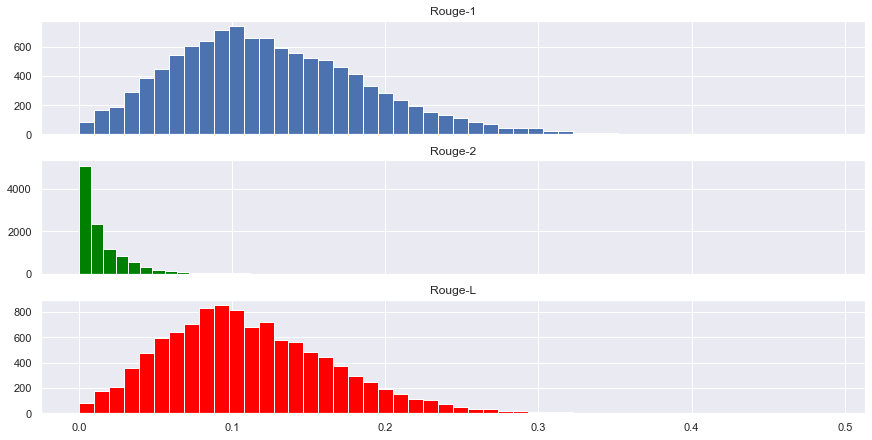

In [18]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green")
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

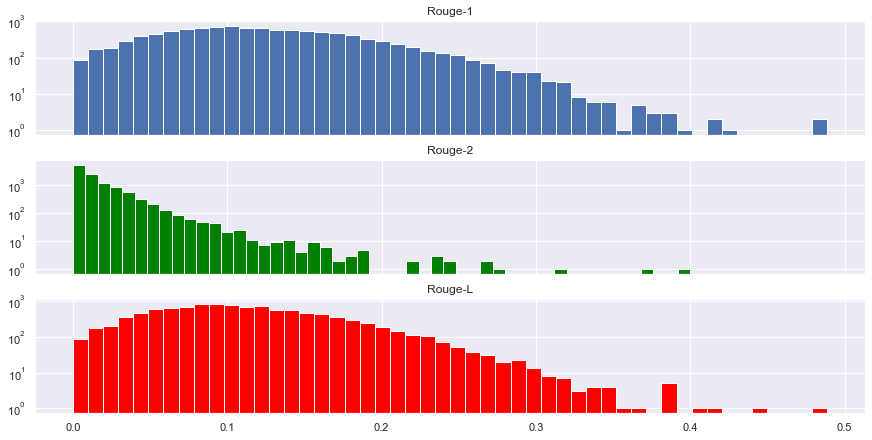

In [19]:
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].hist(full_rouge.rouge_1_f, bins = 50, log = True)
ax[0].set_title("Rouge-1")
ax[1].hist(full_rouge.rouge_2_f, bins = 50, color = "green", log = True)
ax[1].set_title("Rouge-2")
ax[2].hist(full_rouge.rouge_l_f, bins = 50, color = "red", log = True)
ax[2].set_title("Rouge-L")

plt.show()

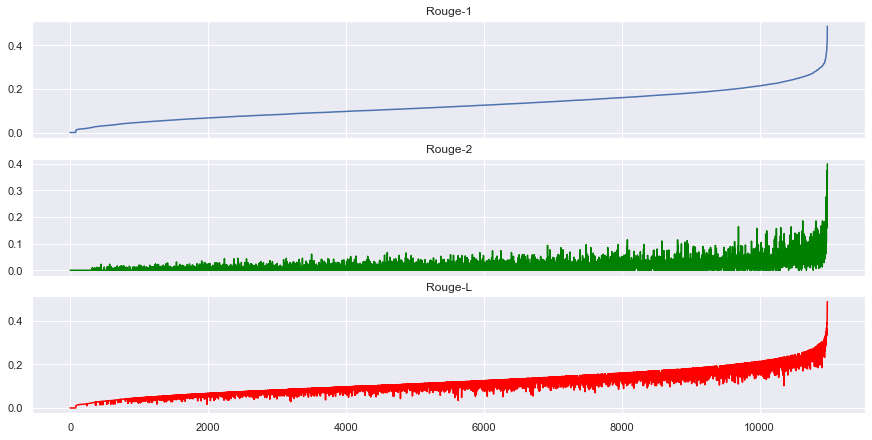

In [20]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1")
ax[1].plot(data.rouge_2_f, color = "green")
ax[1].set_title("Rouge-2")
ax[2].plot(data.rouge_l_f, color = "red")
ax[2].set_title("Rouge-L")

plt.show()

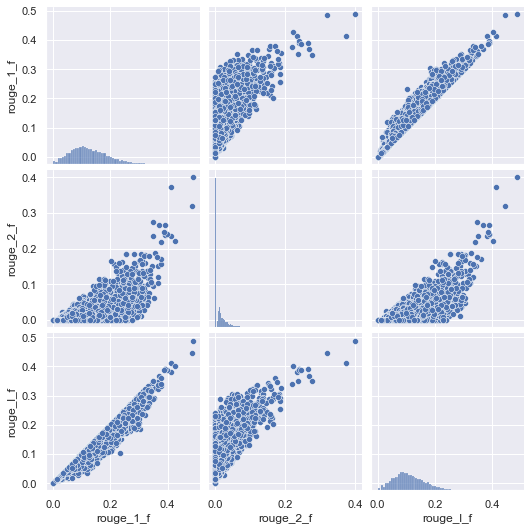

In [21]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_2_f", "rouge_l_f"])
plt.show()

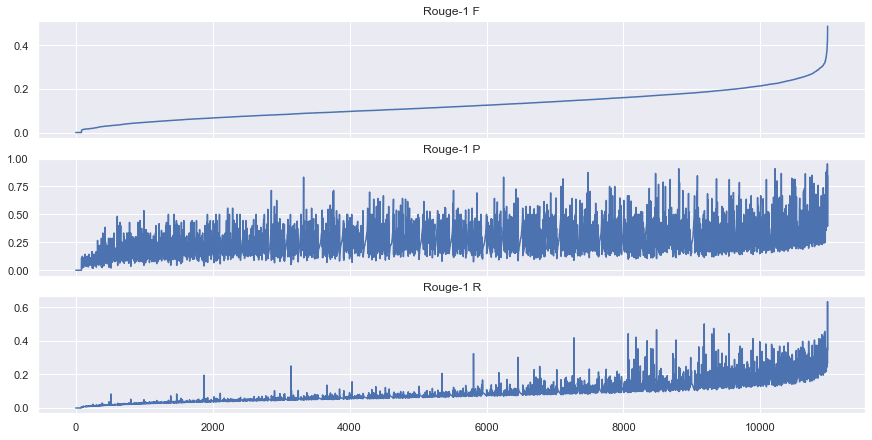

In [22]:
data = full_rouge.sort_values("rouge_1_f").reset_index()
f, ax = plt.subplots(3, 1, sharex = True, constrained_layout=True, figsize = (12, 6))
ax[0].plot(data.rouge_1_f)
ax[0].set_title("Rouge-1 F")
ax[1].plot(data.rouge_1_p)
ax[1].set_title("Rouge-1 P")
ax[2].plot(data.rouge_1_r)
ax[2].set_title("Rouge-1 R")

plt.show()

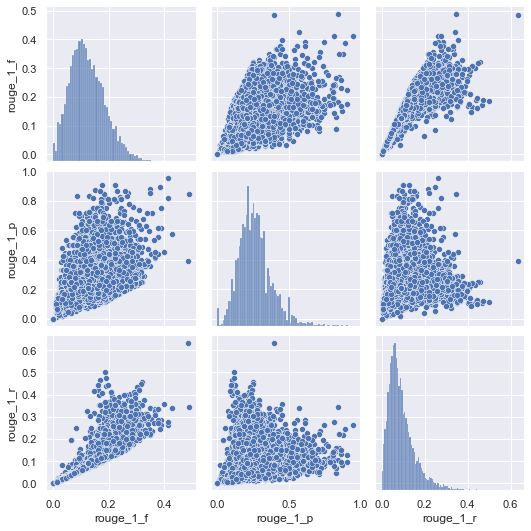

In [23]:
sns.pairplot(full_rouge, vars = ["rouge_1_f","rouge_1_p", "rouge_1_r"])
plt.show()

# worst

In [24]:
for d in full_rouge.sort_values("rouge_1_f").head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", global_reference_id:", d["global_reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*30)

paper_id: 523 , global_reference_id: 790
rouge 1 f: 0.0

, 2019), OpenNMT (Klein et al., 2017), Texar (Hu et al.

We describe an open-source toolkit for neural machine translation (NMT). The toolkit prioritizes efficiency, modularity, and extensibility with the goal of supporting NMT research into model architectures, feature representations, and source modalities, while maintaining competitive performance and reasonable training requirements. The toolkit consists of modeling and translation support, as well as detailed pedagogical documentation about the underlying techniques.
******************************
paper_id: 689 , global_reference_id: 12474
rouge 1 f: 0.0

, DeepMoji (Felbo et al., 2017), Skip thoughts (Kiros et al.

NLP tasks are often limited by scarcity of manually annotated data. In social media sentiment analysis and related tasks, researchers have therefore used binarized emoticons and specific hashtags as forms of distant supervision. Our paper shows that by extending 

# best

In [25]:
for d in full_rouge.sort_values("rouge_1_f", ascending = False).head().to_dict("records"):
    print("paper_id:", d["paper_id"], ", global_reference_id:", d["global_reference_id"])
    print("rouge 1 f:", d["rouge_1_f"])
    print()
    print(d["hypothesis"])
    print()
    print(d["reference"])
    print("*"*100)

paper_id: 12 , global_reference_id: 15779
rouge 1 f: 0.48888888478024695

Zhang and Yang [149] proposed a lattice-structured LSTM model for Chinese NER, which encodes a sequence of input characters as well as all potential words that match a lexicon.

We investigate a lattice-structured LSTM model for Chinese NER, which encodes a sequence of input characters as well as all potential words that match a lexicon. Compared with character-based methods, our model explicitly leverages word and word sequence information. Compared with word-based methods, lattice LSTM does not suffer from segmentation errors. Gated recurrent cells allow our model to choose the most relevant characters and words from a sentence for better NER results. Experiments on various datasets show that lattice LSTM outperforms both word-based and character-based LSTM baselines, achieving the best results.
****************************************************************************************************
paper_id: 145 , 

In [26]:
full_rouge[["rouge_1_f", "rouge_2_f", "rouge_l_f"]].describe(percentiles = np.linspace(0, 1, 11))

,rouge_1_f,rouge_2_f,rouge_l_f
count,10984.000000,10984.000000,10984.000000
mean,0.124963,0.014813,0.111474
std,0.063101,0.022727,0.055978
min,0.000000,0.000000,0.000000
0%,0.000000,0.000000,0.000000
10%,0.048780,0.000000,0.045455
20%,0.070175,0.000000,0.063326
30%,0.087500,0.000000,0.078947
40%,0.102041,0.000000,0.091603
50%,0.117647,0.009456,0.104478
